# Empirical Algorithmic Implementation of Technical Analysis

I recently presented a paper by Andrew Lo, Harry Mamaysky, and Jiang Wang called "Foundations of Technical Analysis: Computational Algorithms, Statistical Inference, and Empirical Implementation (2000)" at Quantopian's journal club. In the paper, the authors utilize non-parametric kernel regression to smooth a stock's daily price time series to a point where the local minima and maxima that a human technical analyst would find relevant can be separated from noisier short-term price fluctuations. The authors then search these denoised local minima and maxima for a few of the patterns commonly pursued by technical analysts. Once they've identified occurrences of particular patterns, the authors test their predictive power by observing the subsequent forward return on the stock.

For a fuller explanation of what is going on in this notebook, I encourage you to take a look at the original paper: https://www.cis.upenn.edu/~mkearns/teaching/cis700/lo.pdf

It is interesting to note that since this paper was written in 2000 and all the data used in my implementation is from 2003-2016, my results can be considered to be "out of sample" with respect to the authors' findings.

In [128]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg
from numpy import linspace
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
from yahoofinancials import YahooFinancials
import warnings
import pandas_datareader as pdr
plt.style.use('seaborn')

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [129]:
import pandas as pd
from collections import OrderedDict
import pytz
import pandas_datareader as pdr

def get_from_pdr_to_panel(symbol="NVDA", datefrom="2016-01-01", dateto="2018-01-01"):
    nvidia=pdr.get_data_yahoo(symbol, datefrom, dateto)
    nvidia.head()
    data = OrderedDict()
    data[symbol] = nvidia
    data[symbol] = data[symbol][["Open","High","Low","Close","Volume"]]
    #print(data[symbol].head())
    panel = pd.Panel(data)
    panel.minor_axis = ["open","high","low","close","volume"]
    panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
    print(panel)
    return panel

In [130]:
msft_prices = pdr.get_data_yahoo('MSFT', '2003-1-1', '2016-5-1')['Close']

In [131]:
msft_prices.head()

Date
2003-01-02    26.860001
2003-01-03    26.895000
2003-01-06    27.385000
2003-01-07    27.900000
2003-01-08    27.120001
Name: Close, dtype: float64

In [132]:
prices_ = msft_prices.copy()
prices_.index = linspace(1., len(prices_), len(prices_))


In [133]:
# I've chosen bandwith parameters manually. This is something that could be improved.
kr = KernelReg([prices_.values], [prices_.index.values], var_type='c', bw=np.full((1, 1), 1.8))
f = kr.fit([prices_.index.values])
smooth_prices = pd.Series(data=f[0], index=msft_prices.index)

In our application, a kernel regression estimates some function $m(x)$ given (time, price) observations $(x_1, P_1) ... (x_t, P_t)$ where $t = 1...T$. The value of $m(x)$ is computed by taking weighted average of the prices in the timeseries, where the weight assigned to observation $P_t$ is determinded by its distance from x. This distance weight is described by a "kernel" fuction $w(x)$. The authors use a gausian kernel with a manually tuned bandwidth parameter.


$$m(x) = \frac{1}{T}\sum_{t=1}^{T}w_t(x)P_t$$ 



In [134]:
msft_prices.head()

Date
2003-01-02    26.860001
2003-01-03    26.895000
2003-01-06    27.385000
2003-01-07    27.900000
2003-01-08    27.120001
Name: Close, dtype: float64

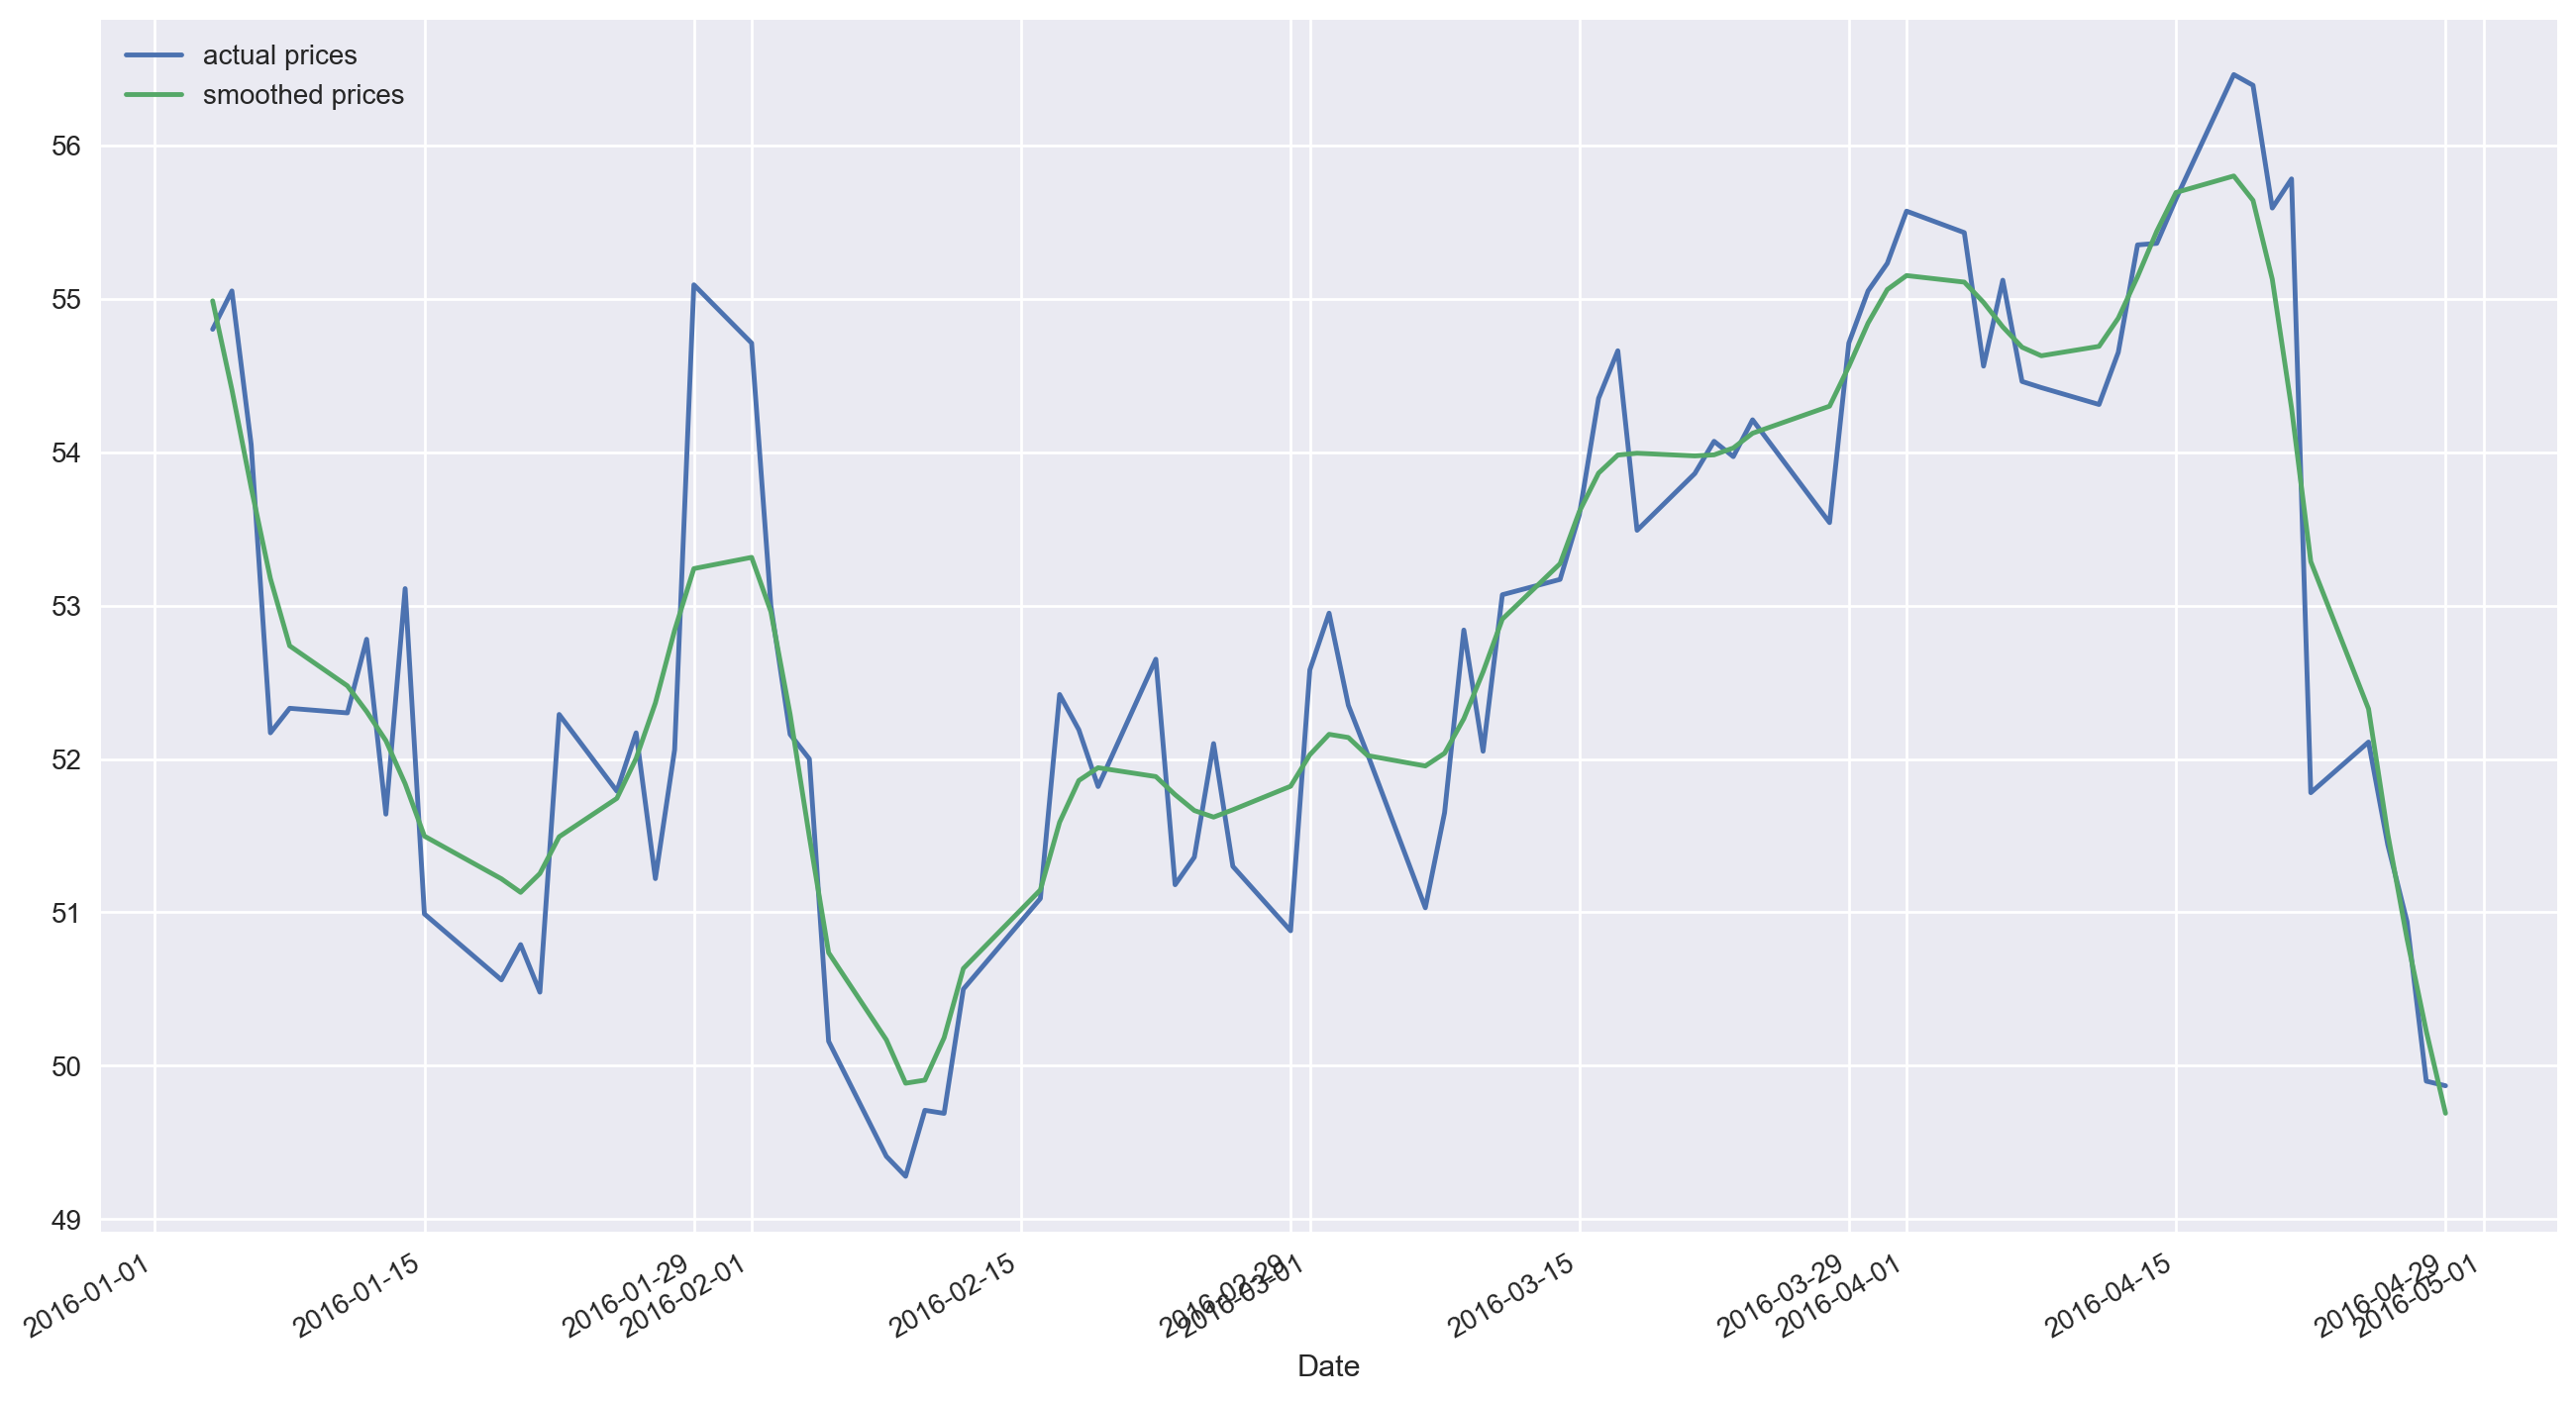

In [135]:
msft_prices.loc[pd.datetime(2016,1,1):].plot()
smooth_prices.loc[pd.datetime(2016,1,1):].plot()
plt.legend(['actual prices', 'smoothed prices'])

From this smoothed price timeseries we can extract local minima and maxima (orange points in the plots below.)

The author use the minima and maxima from the smoothed timeseries to identify true local minima and maxima in the original timeseres by taking the maximum/minimum price within a t-1, t+1 window around the smooth timeseries maxima/minima (purple points in the plots below). We use these minima and maxima from the original price data to look for the given technical patterns.

You can see in the plots below, that finding minima and maxima using the kernel regression allows us to skip over minima and maxima that are *too local*.

In [136]:
from scipy.signal import argrelextrema

In [137]:
local_max = argrelextrema(smooth_prices.values, np.greater)[0]
local_min = argrelextrema(smooth_prices.values, np.less)[0]

In [138]:
local_max_dt = smooth_prices.iloc[local_max].index.values
local_min_dt = smooth_prices.iloc[local_min].index.values

In [139]:
price_local_max_dt = []
for i in local_max:
    if (i>1) and (i<len(msft_prices)-1):
        price_local_max_dt.append(msft_prices.iloc[i-2:i+2].argmax())

price_local_min_dt = []
for i in local_min:
    if (i>1) and (i<len(msft_prices)-1):
        price_local_min_dt.append(msft_prices.iloc[i-2:i+2].argmin())

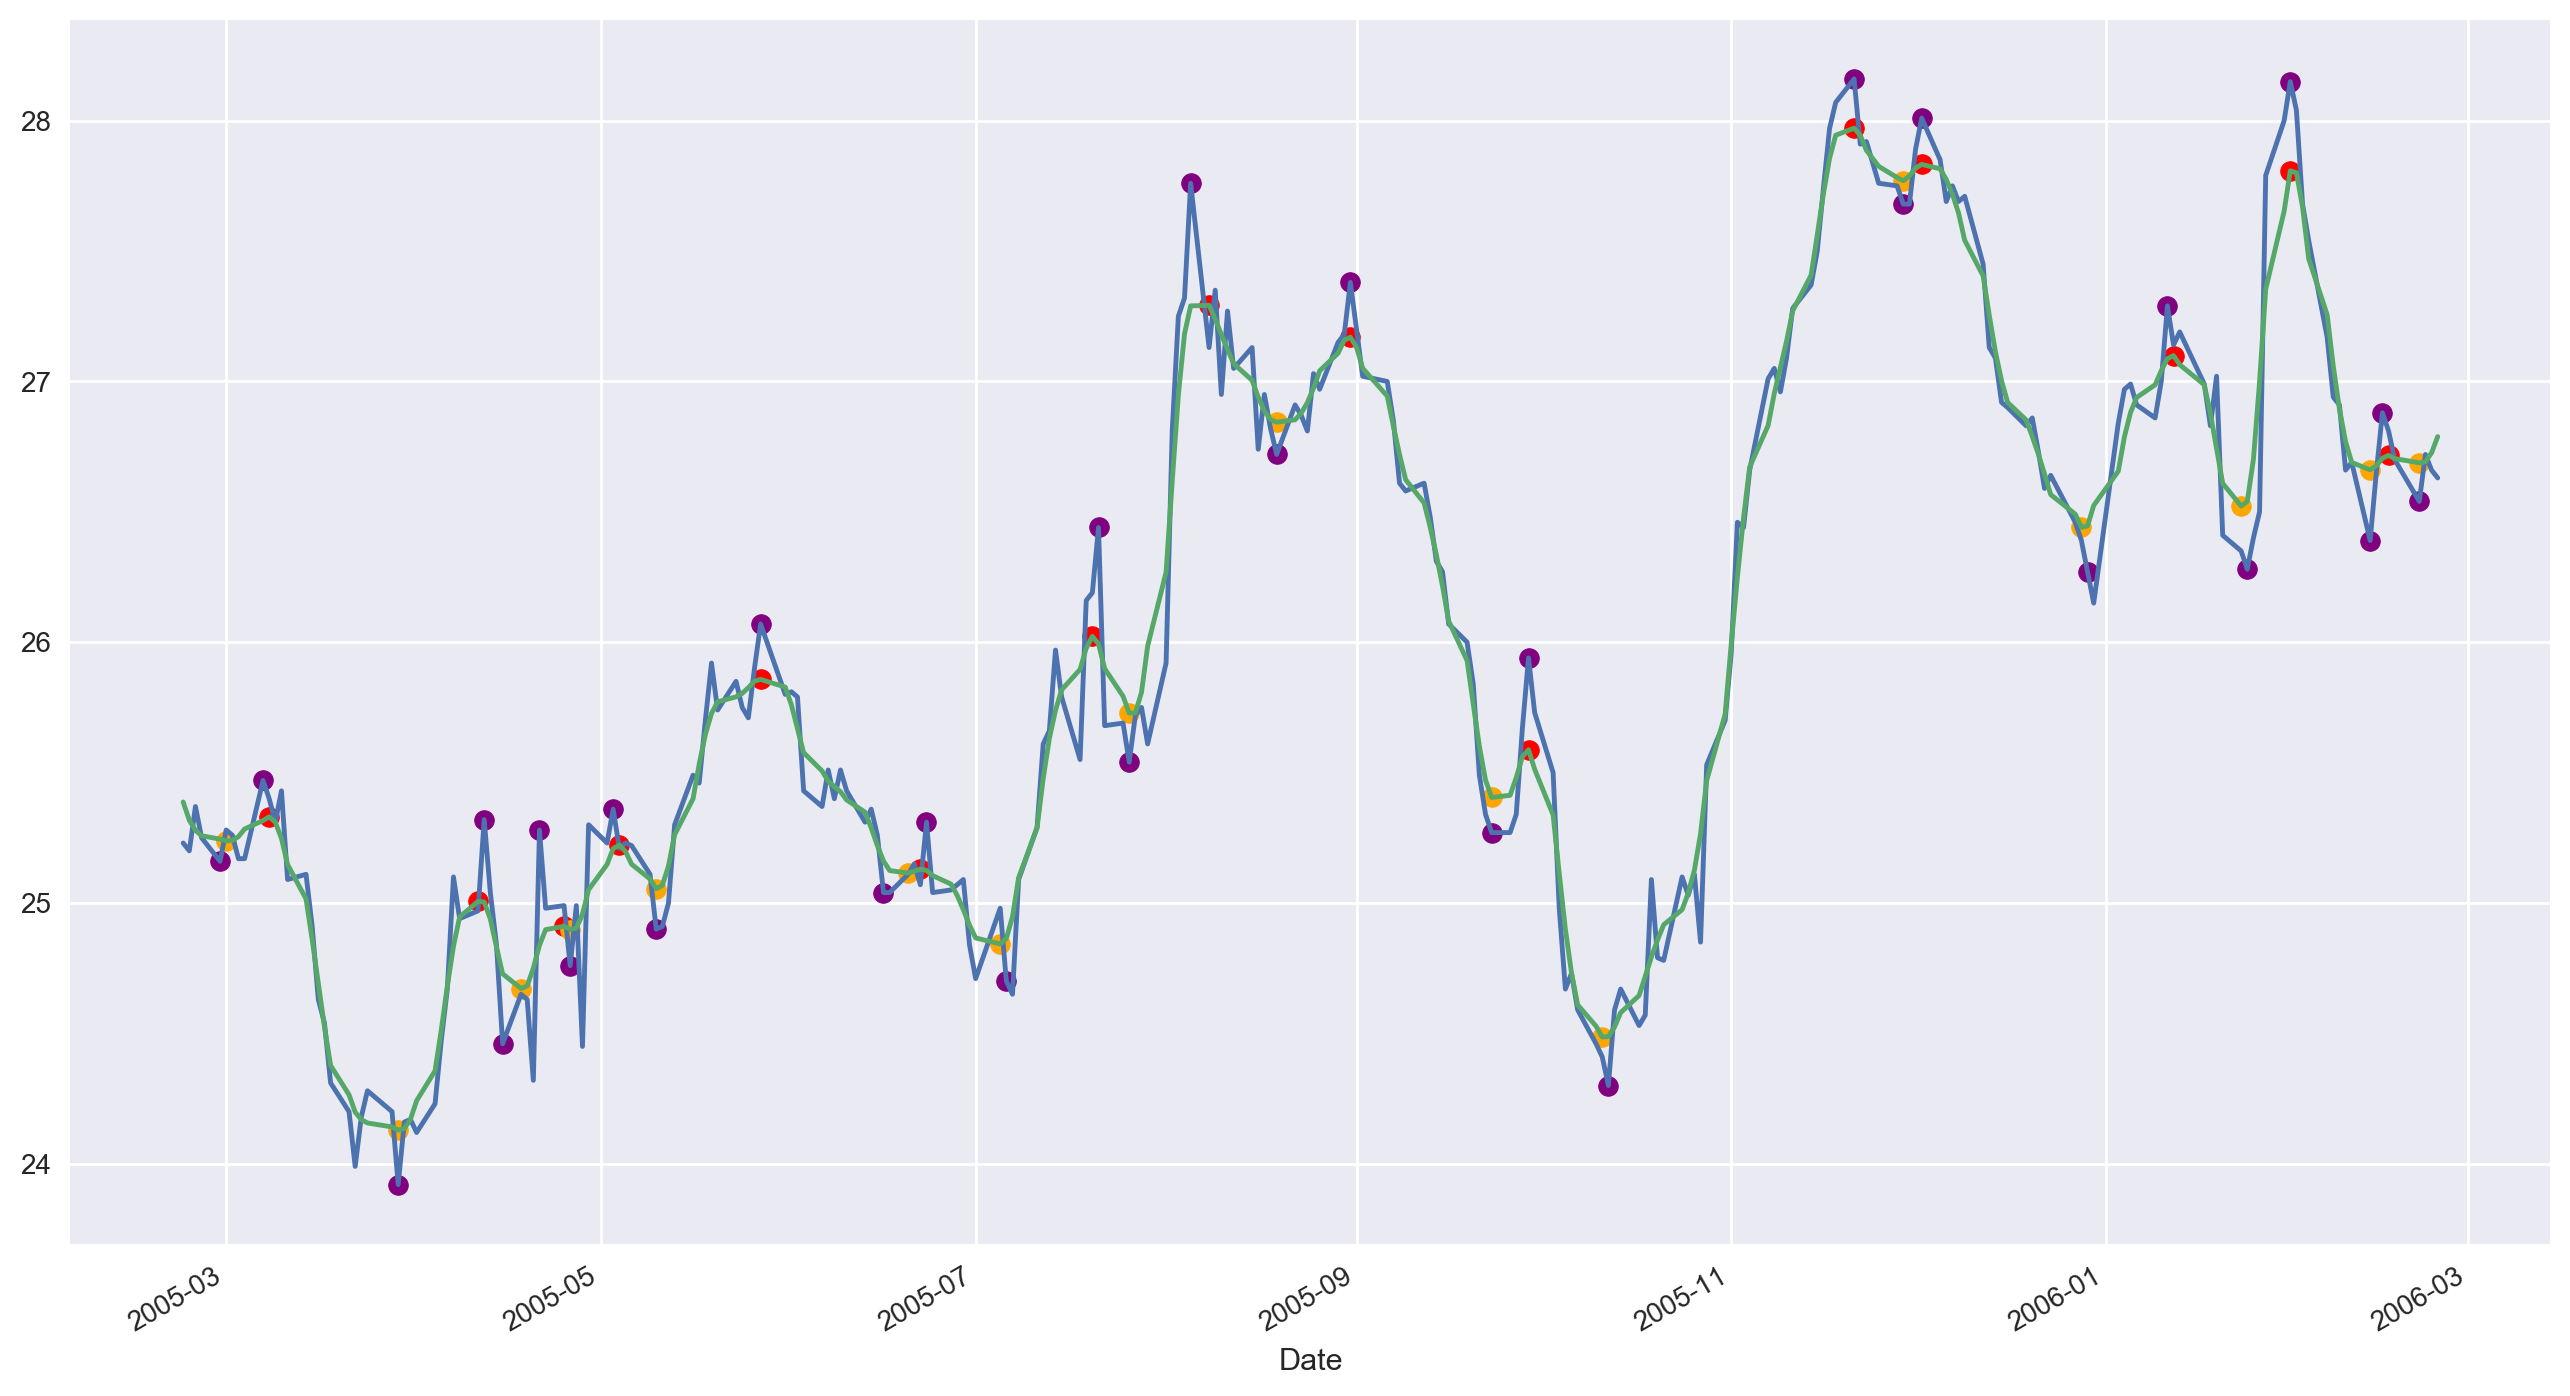

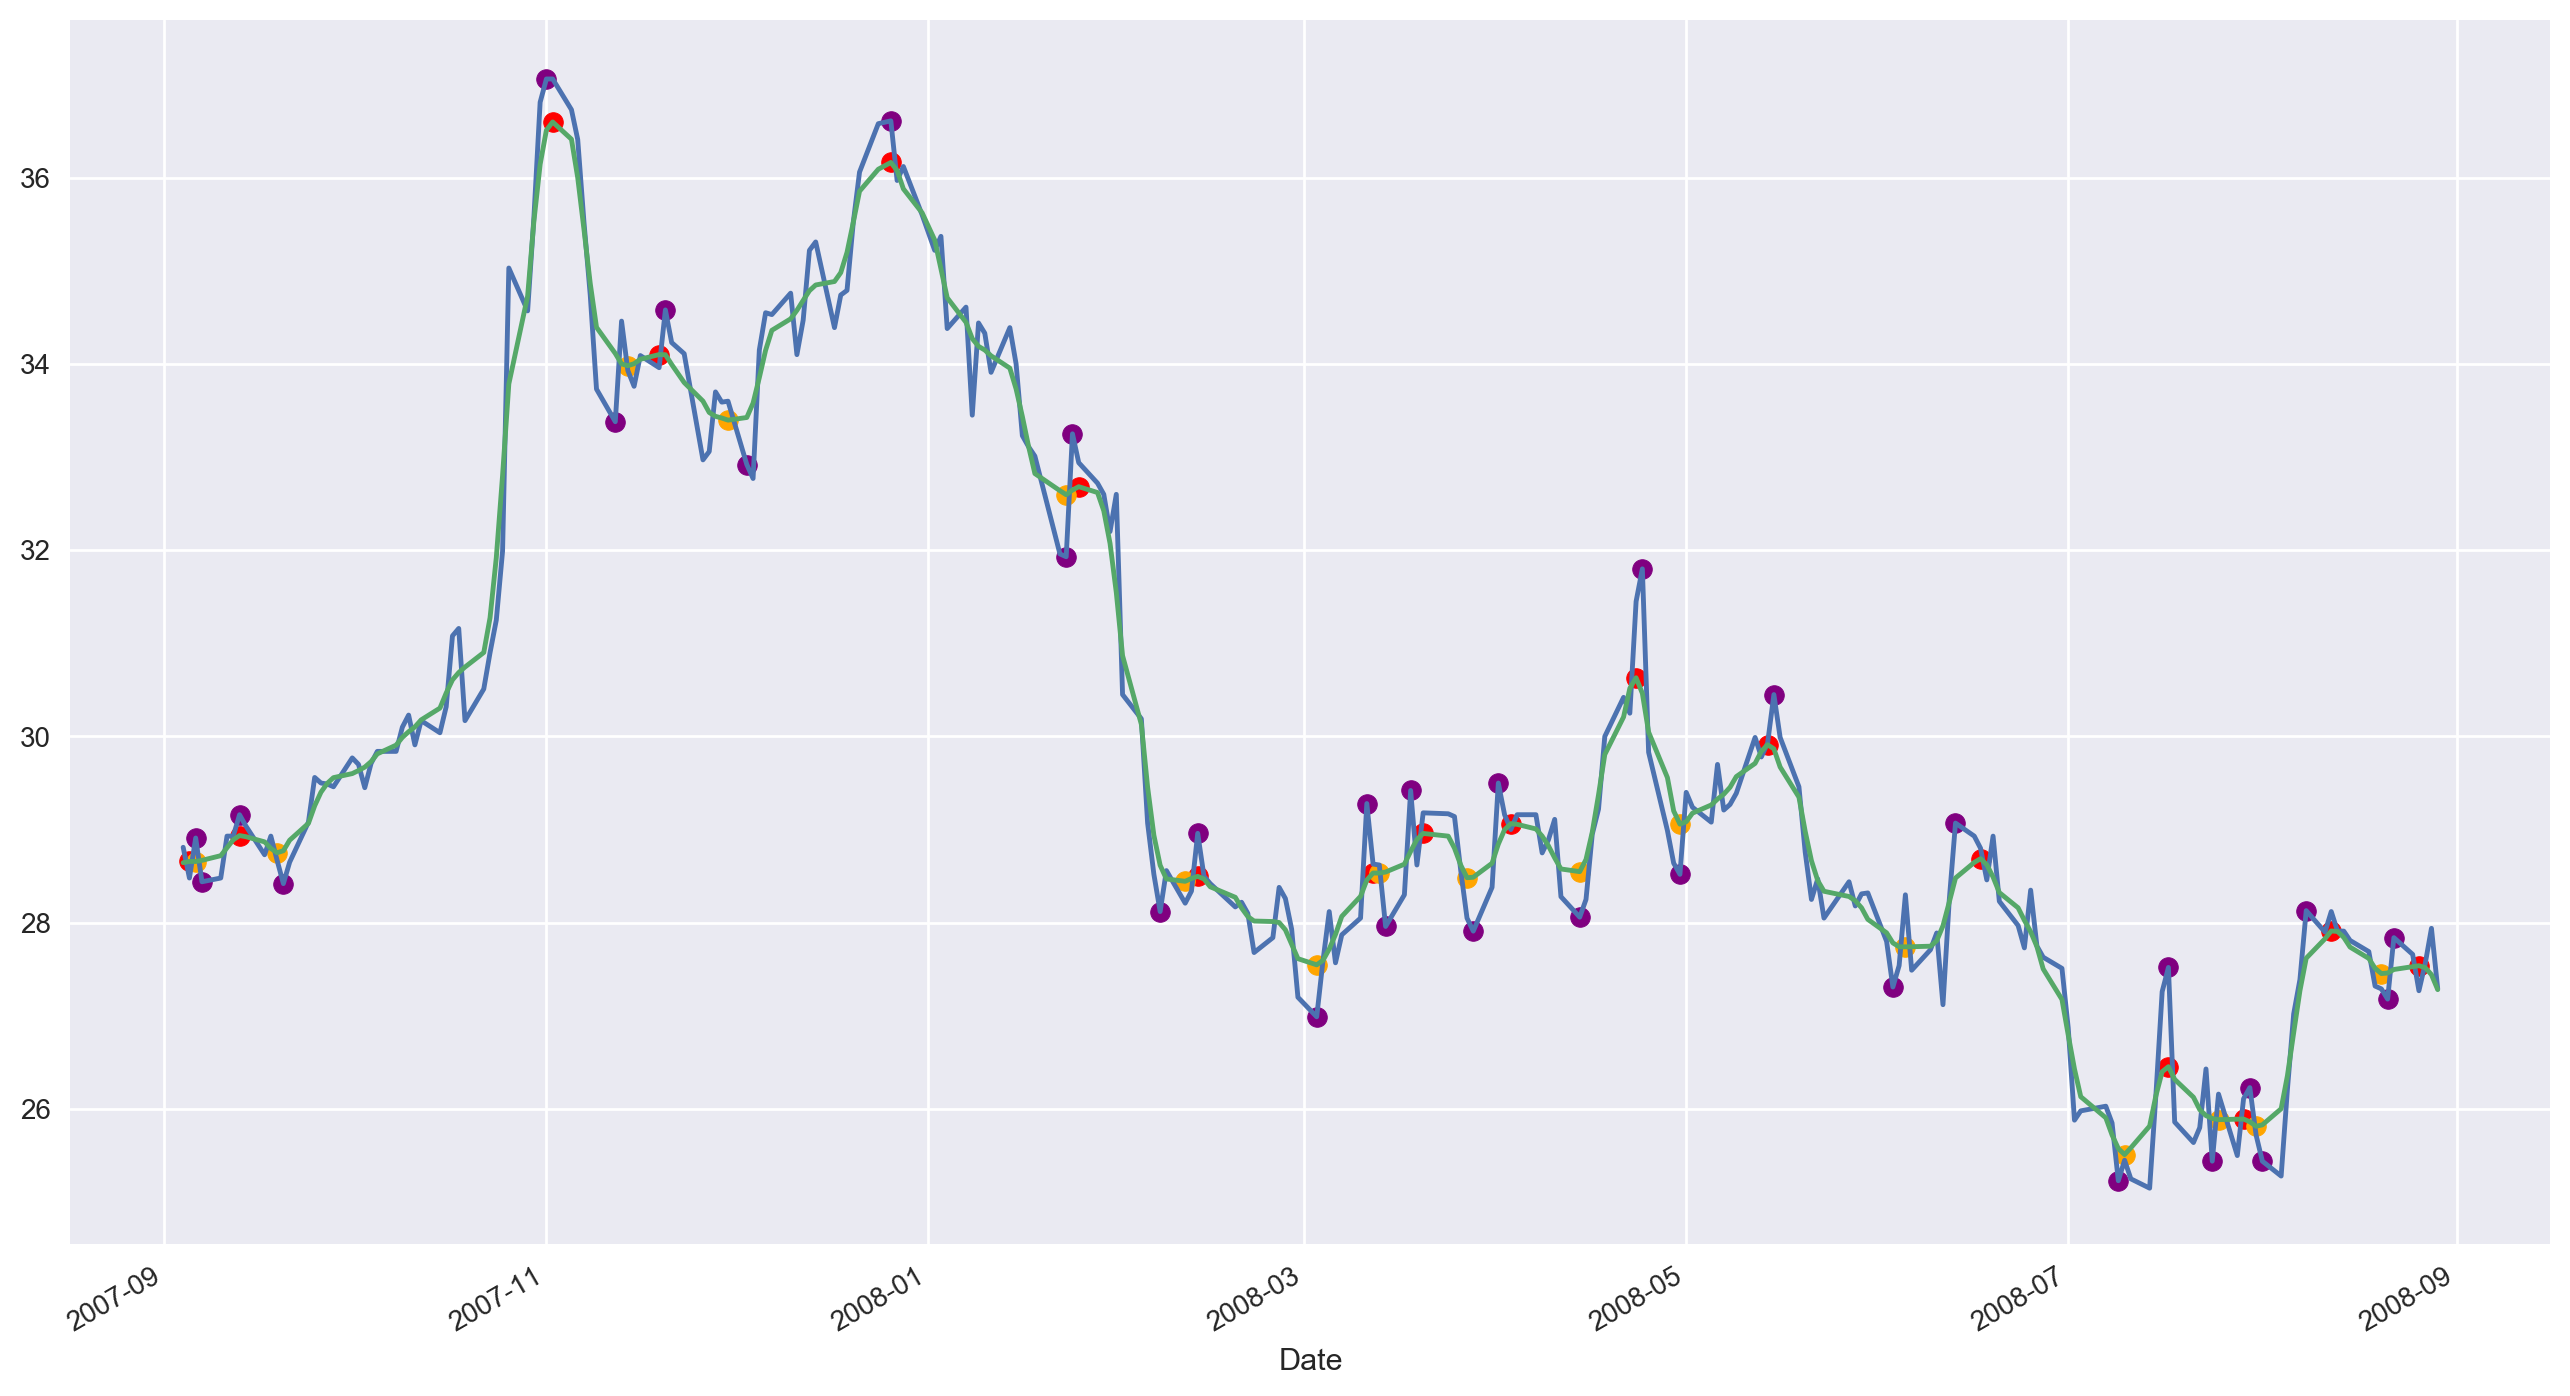

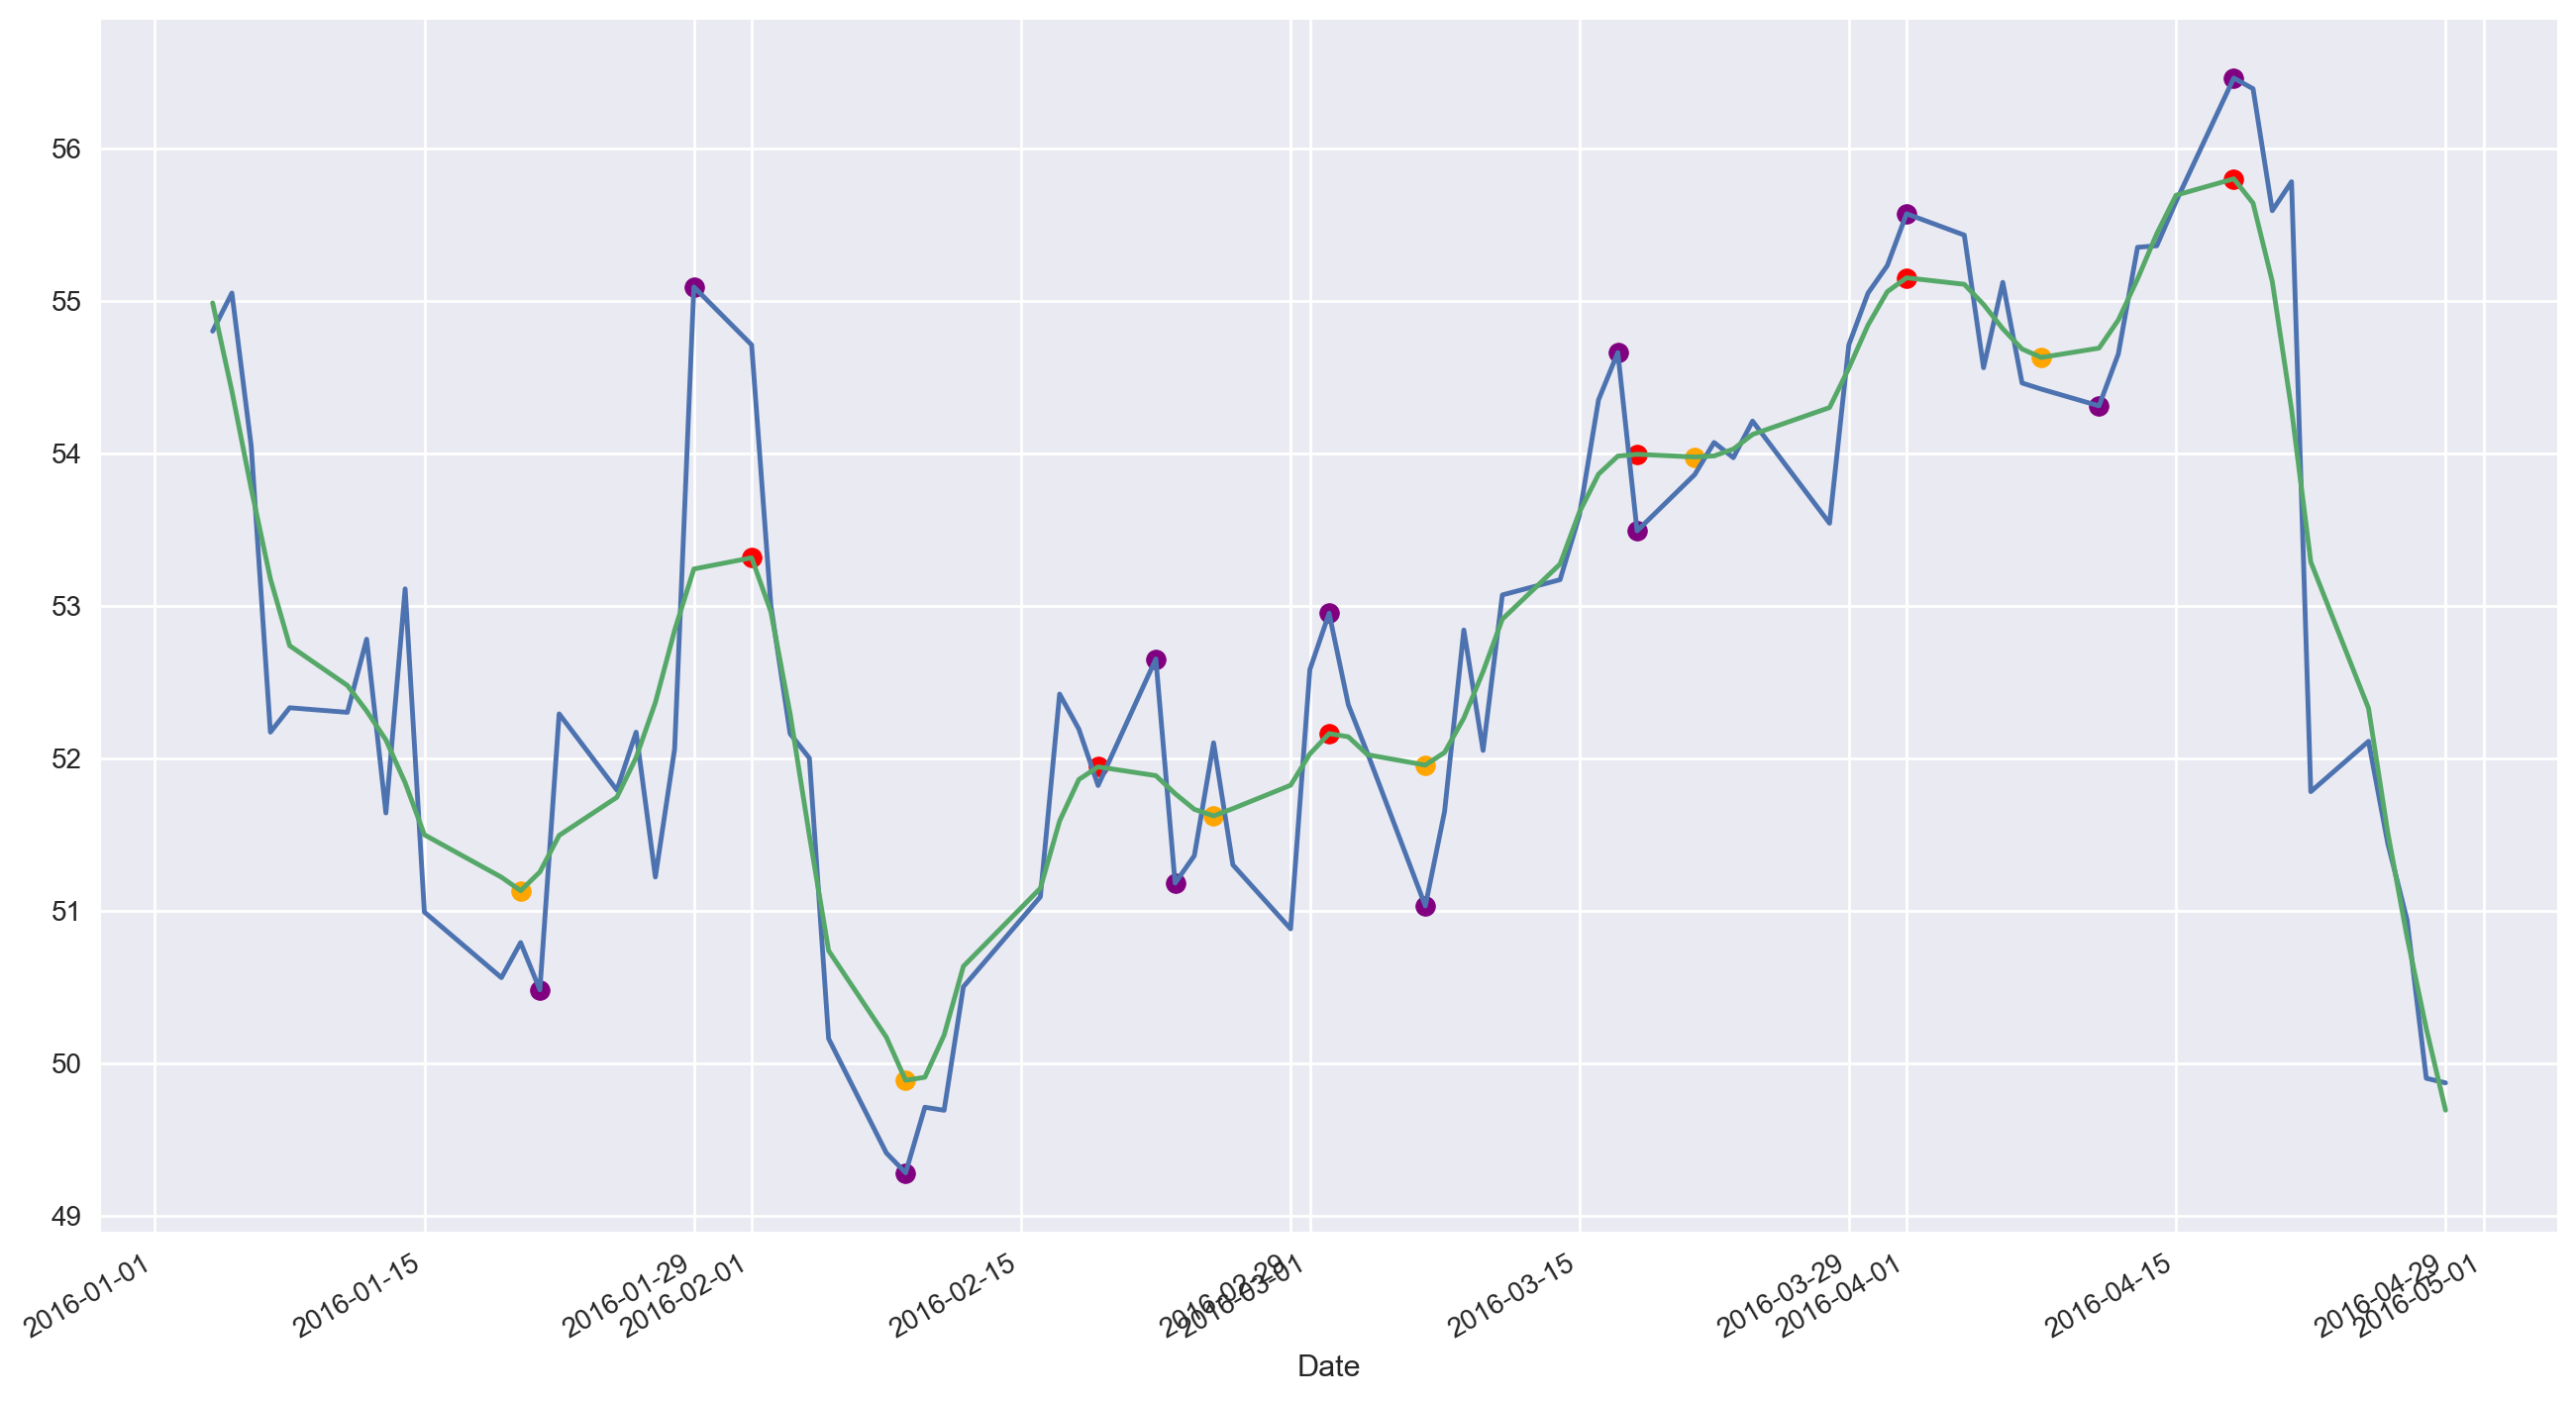

In [154]:
start = pd.datetime(2015,1,1)
end = pd.datetime(2015,4,1)

def plot_window(prices, smooth_prices, smooth_maxima_dt, smooth_minima_dt,
                price_maxima_dt, price_minima_dt, start, end, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    prices_ = prices.loc[start:end]
    prices_.plot(ax=ax)
    smooth_prices_ = smooth_prices.loc[start:end]
    smooth_prices_.plot(ax=ax)
    
    smooth_max = smooth_prices_.loc[smooth_maxima_dt]
    smooth_min = smooth_prices_.loc[smooth_minima_dt]
    price_max = prices_.loc[price_maxima_dt]
    price_min = prices_.loc[price_minima_dt]
    
    #print(type(smooth_max.index.values[0]))
    smooth_max.index= [pd.to_datetime(d) for d in smooth_max.index.values]

    ax.scatter(smooth_max.index.values, smooth_max.values, s=50, color='red' )
    ax.scatter(smooth_min.index.values, smooth_min.values, s=50, color='orange')
    
    ax.scatter(price_max.index.values, price_max.values, s=50, color='purple')
    ax.scatter(price_min.index.values, price_min.values, s=50, color='purple')
    
plot_window(msft_prices, smooth_prices, local_max_dt, local_min_dt, price_local_max_dt, 
            price_local_min_dt, pd.datetime(2005,2,19), pd.datetime(2006,2,26))
plot_window(msft_prices, smooth_prices, local_max_dt, local_min_dt, price_local_max_dt, 
            price_local_min_dt,pd.datetime(2007,9,1), pd.datetime(2008,9,1))
plot_window(msft_prices, smooth_prices, local_max_dt, local_min_dt, price_local_max_dt, 
            price_local_min_dt, pd.datetime(2016,1,1), pd.datetime(2016,5,1))

In [141]:
# Let's throw what we have so far into a function:
def find_max_min(prices):
    prices_ = prices.copy()
    prices_.index = linspace(1., len(prices_), len(prices_))
    kr = KernelReg([prices_.values], [prices_.index.values], var_type='c',  bw=np.full((1, 1), 1.8))
    f = kr.fit([prices_.index.values])
    smooth_prices = pd.Series(data=f[0], index=prices.index)
    
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    
    price_local_max_dt = []
    for i in local_max:
        if (i>1) and (i<len(prices)-1):
            price_local_max_dt.append(prices.iloc[i-2:i+2].argmax())

    price_local_min_dt = []
    for i in local_min:
        if (i>1) and (i<len(prices)-1):
            price_local_min_dt.append(prices.iloc[i-2:i+2].argmin())
        
    prices.name = 'price'
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()
    max_min['day_num'] = p[p['Date'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num').price
    
    return max_min

In [142]:
max_min = find_max_min(msft_prices)

# Pattern Identification

You can find the pattern definitions on page 1716 of the paper. 

In [143]:
from collections import defaultdict

def find_patterns(max_min):
    patterns = defaultdict(list)

    for i in range(5, len(max_min)):
        window = max_min.iloc[i-5:i]

        # pattern must play out in less than 36 days
        if window.index[-1] - window.index[0] > 35:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1,e3,e5])
        rtop_g2 = np.mean([e2,e4])
        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
            (abs(e1 - e5) <= 0.03*np.mean([e1,e5])) and \
            (abs(e2 - e4) <= 0.03*np.mean([e1,e5])):
                patterns['HS'].append((window.index[0], window.index[-1]))

        # Inverse Head and Shoulders
        elif (e1 < e2) and (e3 < e1) and (e3 < e5) and \
            (abs(e1 - e5) <= 0.03*np.mean([e1,e5])) and \
            (abs(e2 - e4) <= 0.03*np.mean([e1,e5])):
                patterns['IHS'].append((window.index[0], window.index[-1]))

        # Broadening Top
        elif (e1 > e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['BTOP'].append((window.index[0], window.index[-1]))

        # Broadening Bottom
        elif (e1 < e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['BBOT'].append((window.index[0], window.index[-1]))

        # Triangle Top
        elif (e1 > e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['TTOP'].append((window.index[0], window.index[-1]))

        # Triangle Bottom
        elif (e1 < e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['TBOT'].append((window.index[0], window.index[-1]))

        # Rectangle Top
        elif (e1 > e2) and (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
            (min(e1, e3, e5) > max(e2, e4)):

            patterns['RTOP'].append((window.index[0], window.index[-1]))

        # Rectangle Bottom
        elif (e1 < e2) and (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
            (max(e1, e3, e5) > min(e2, e4)):
            patterns['RBOT'].append((window.index[0], window.index[-1]))
            
    return patterns


In [144]:
patterns = find_patterns(max_min)

In [145]:
# import datetime
# local_max_dt
# local_max_dt2=[pd.to_datetime('2000-01-01') for i in range(len(local_max_dt))]
# local_min_dt2=[pd.to_datetime('2000-01-01') for i in range(len(local_max_dt))]
# price_local_max_dt2= [pd.to_datetime('2000-01-01') for i in range(len(local_max_dt))]
# price_local_min_dt2= [pd.to_datetime('2000-01-01') for i in range(len(local_max_dt))]

# for i in range(len(local_max_dt)):
#     local_max_dt2[i]= np.datetime64(pd.to_datetime(str(local_max_dt[i])).strftime('%Y-%m-%d'))
    
# for i in range(len(local_min_dt)):
#     local_min_dt2[i]= np.datetime64(pd.to_datetime(str(local_min_dt[i])).strftime('%Y-%m-%d'))

# for i in range(len(price_local_max_dt)):
#     price_local_max_dt2[i]= np.datetime64(pd.to_datetime(price_local_max_dt[i]).strftime('%Y-%m-%d'))

# for i in range(len(price_local_min_dt)):
#     price_local_min_dt2[i]= np.datetime64(pd.to_datetime(price_local_min_dt[i]).strftime('%Y-%m-%d'))

    
# local_max_dt= local_max_dt2
# local_min_dt= local_min_dt2
# price_local_min_dt= price_local_min_dt2
# price_local_max_dt=price_local_max_dt2

In [146]:
# msft_prices.head()

Visualizing pattern occurences

TTOP


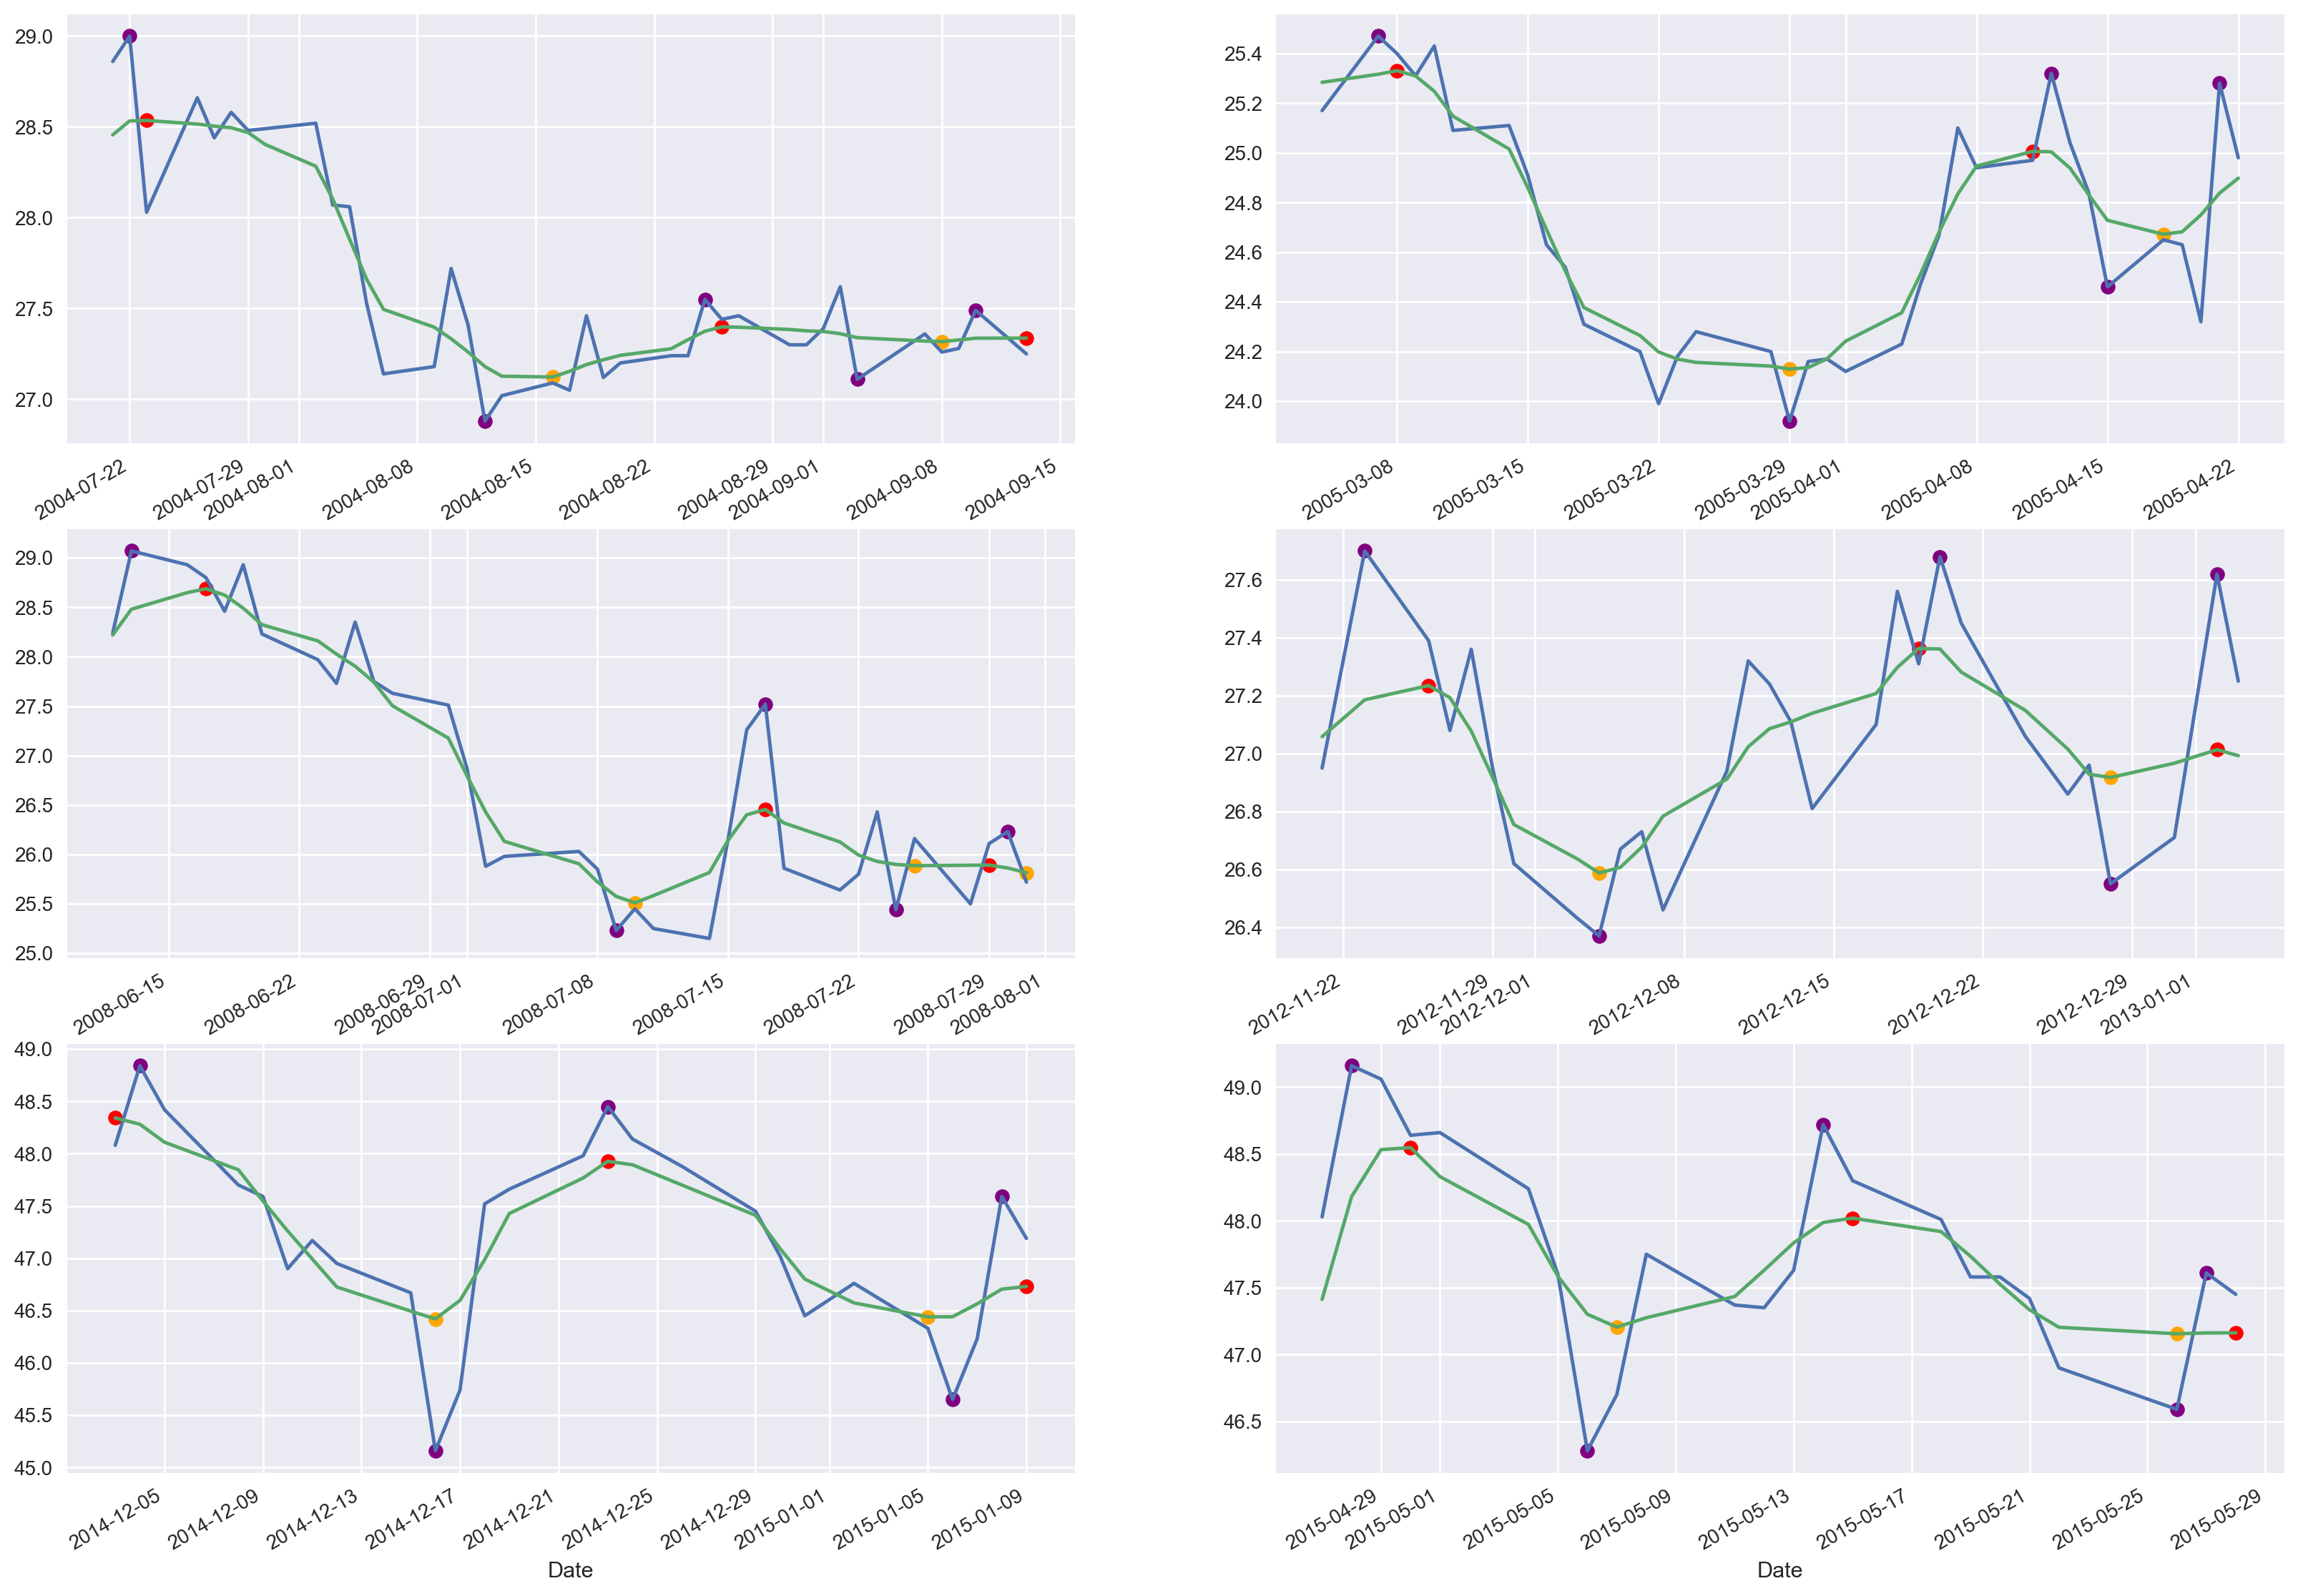

BTOP


ValueError: Unrecognizable date '2003-01-13T00:00:00.000000000'

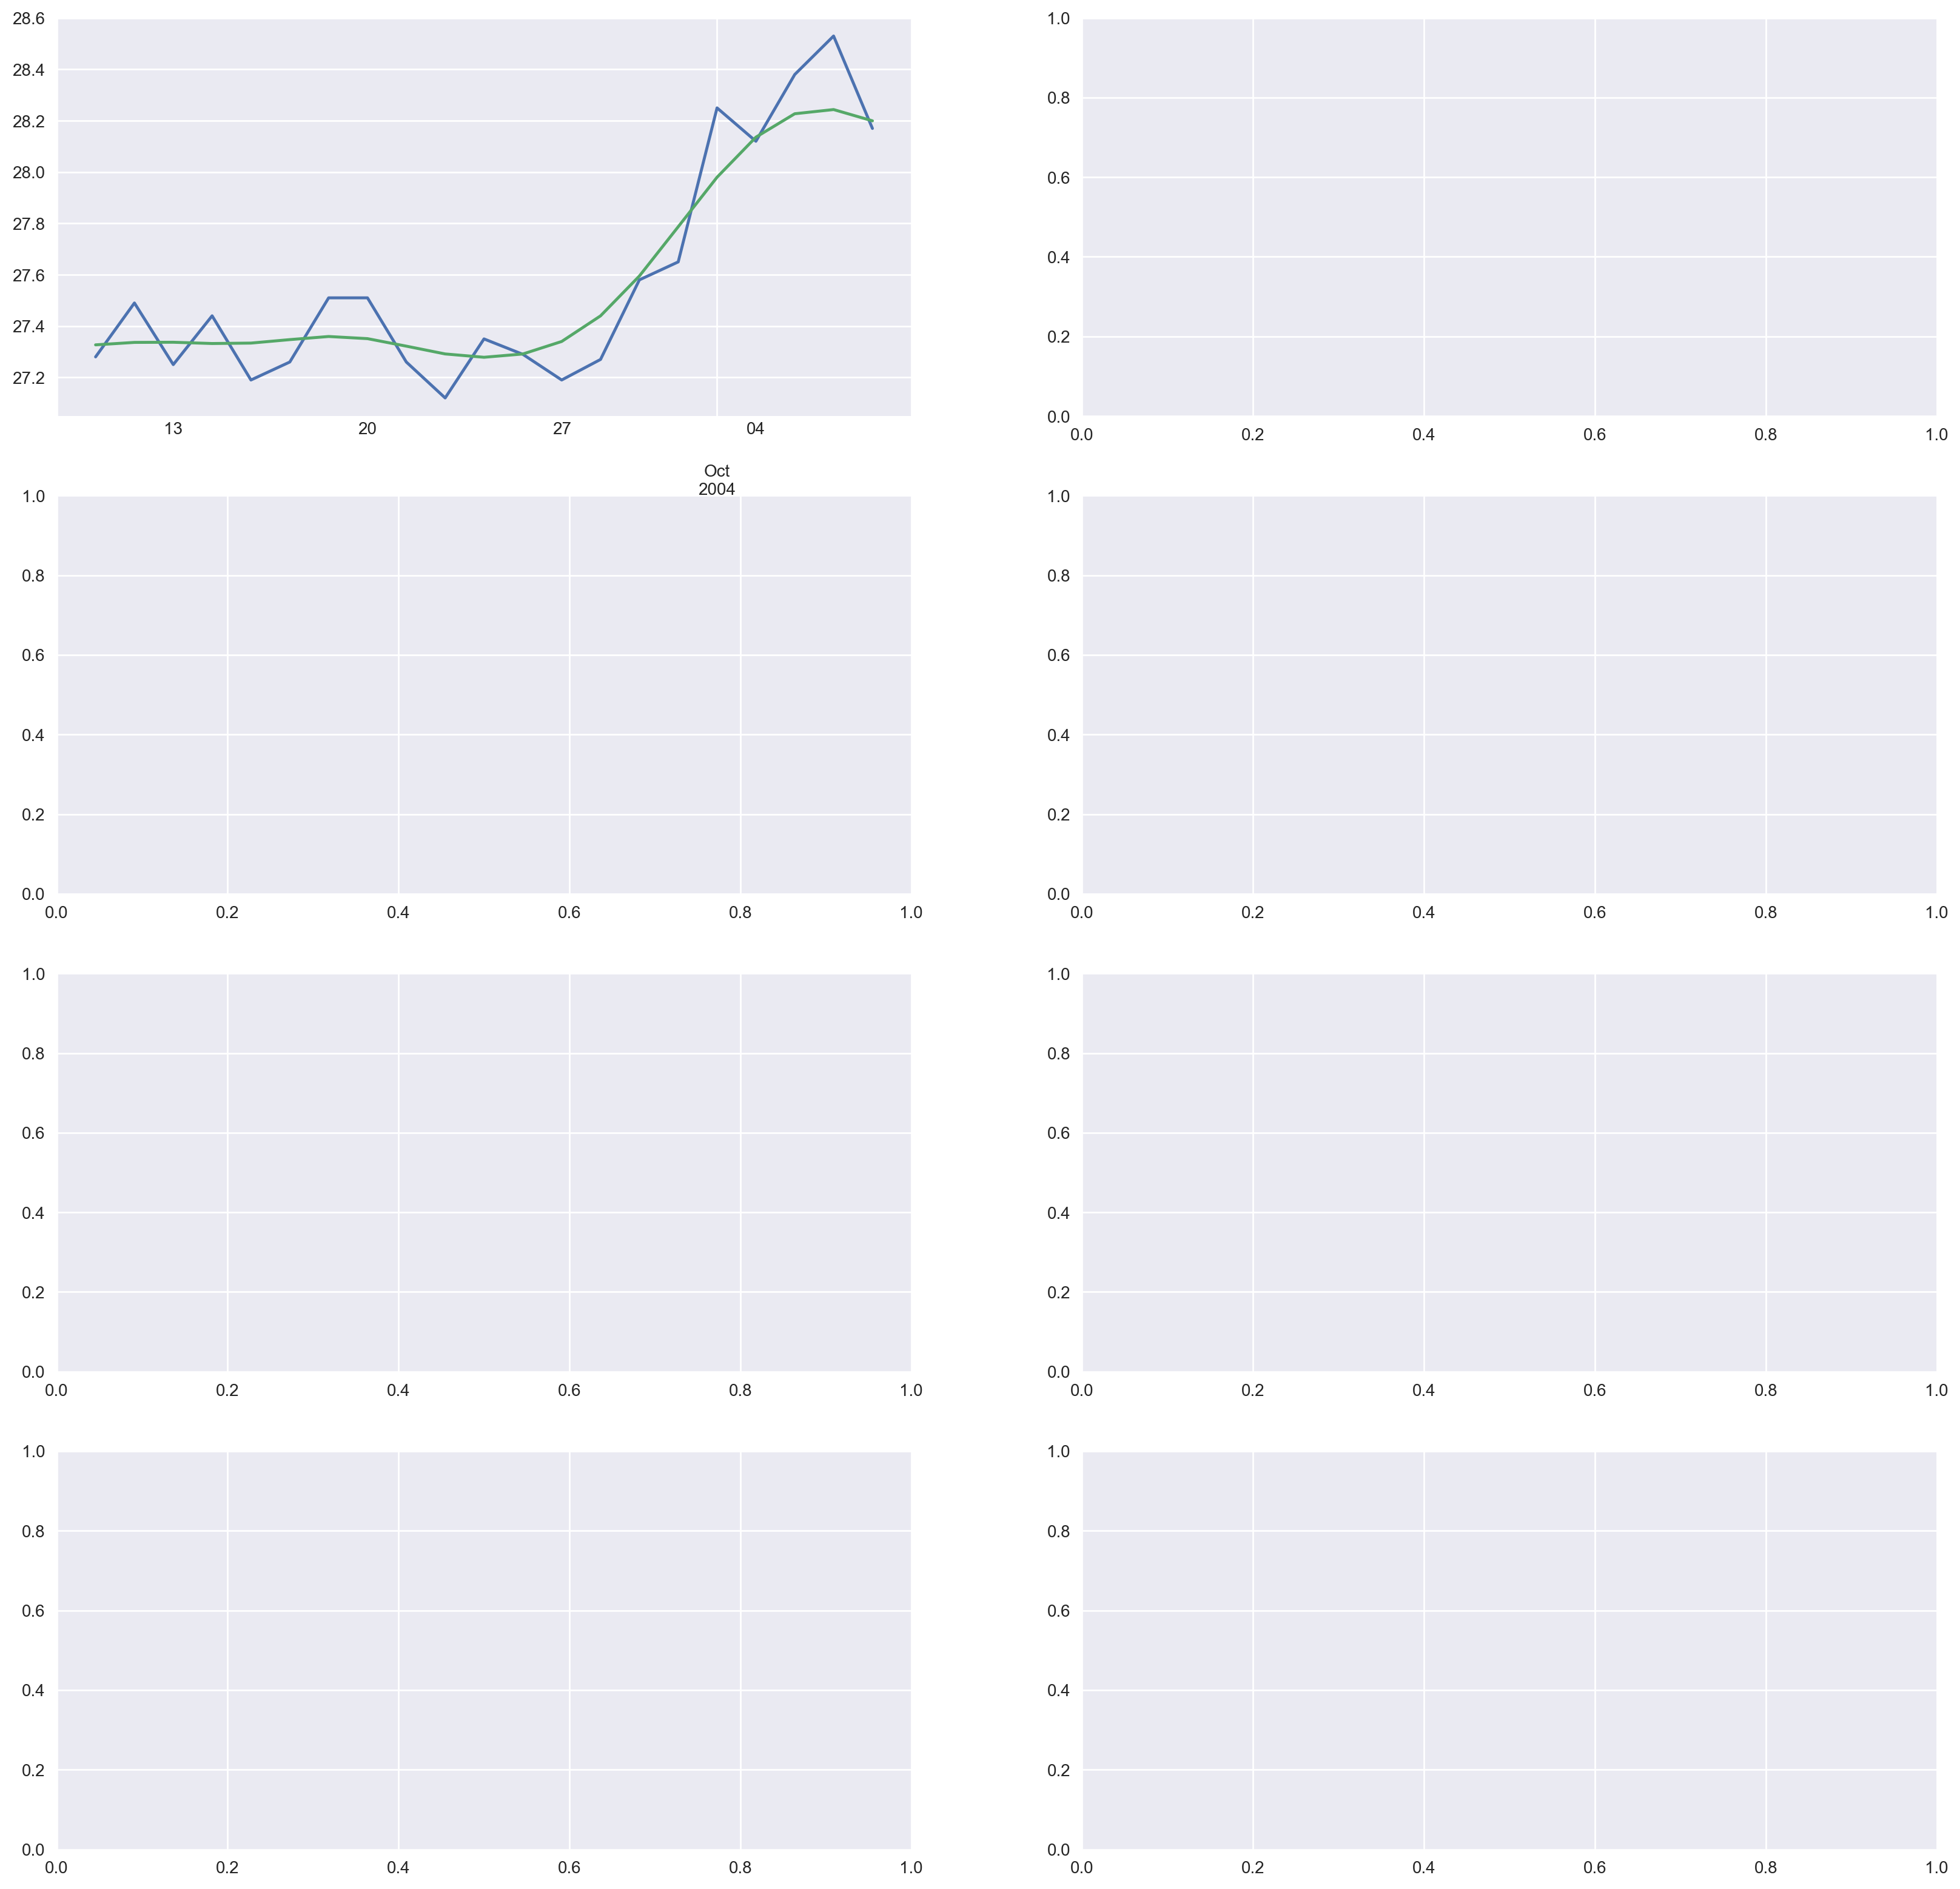

In [155]:
for name, end_day_nums in patterns.items():
    print(name)
    rows = int(np.ceil(len(end_day_nums)/2))
    f, axes = plt.subplots(rows,2, figsize=(20,5*rows))
    axes = axes.flatten()
    i = 0
    for sd, ed in end_day_nums:
        s = msft_prices.index[sd-1]
#         s= np.datetime64(pd.to_datetime(msft_prices.index[sd-1]).strftime('%Y-%m-%d'))
        e = msft_prices.index[ed+1]
#         e= np.datetime64(pd.to_datetime(msft_prices.index[ed+1]).strftime('%Y-%m-%d'))
        plot_window(msft_prices, smooth_prices,local_max_dt, local_min_dt, 
                    price_local_max_dt, price_local_min_dt, s, e, ax=axes[i])
        i+=1
    plt.show()


In [96]:
e

Timestamp('2004-10-07 00:00:00')

In [90]:
np.datetime64('2012-05-01T01:00:00.000000+0100')

E:\anaconda3\envs\env_zipline\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


numpy.datetime64('2012-05-01T00:00:00.000000')

In [157]:
pd.to_datetime('2003-01-13T00:00:00.000000000')

Timestamp('2003-01-13 00:00:00')

In [120]:
smooth_max = smooth_prices_.loc[smooth_maxima_dt]
smooth_min = smooth_prices_.loc[smooth_minima_dt]

NameError: name 'smooth_prices_' is not defined

In [15]:
for name, end_day_nums in patterns.iteritems():
    print("{}: {} occurences".format(name, len(end_day_nums)))

HS: 18 occurences
RTOP: 5 occurences
TTOP: 5 occurences
IHS: 8 occurences
BBOT: 6 occurences
TBOT: 7 occurences
BTOP: 7 occurences


# Predictive Power of Technical Patterns

Next, we want to know if our technical patterns can predict forward returns. The proported return sign predicted by each of the patterns is as follows:

Bullish:
- Inverse Head and Shoulders
- Broadening Bottom 
- Rectangle Bottom
- Triangle Bottom

Bearish:
- Head and Shoulders
- Broadening Top
- Rectangle Top
- Triangle Top

Following the authors, I account for a 4 day "observation lag" before the computing the forward return. This lag makes sense, as you would not know a point is a local max/min until the days after it has been observed. 

I also follow the authors by normalizing forward returns.

In [16]:
def compute_pattern_returns(prices, indentification_lag=4):
    max_min = find_max_min(prices)
    patterns = find_patterns(max_min)
    returns = (prices.pct_change(1)
                          .shift(-1)
                          .reset_index(drop=True)
                          .dropna())

    demeaned_returns = (returns - returns.mean()) / returns.std()

    pattern_mean_returns = pd.Series()
    for name, start_end_day_nums in patterns.iteritems():
        if not isinstance(start_end_day_nums, list):
            end_day_nums = [end_day_nums]
        lagged_end_days = map(lambda x: x[1] + indentification_lag, start_end_day_nums)
        pattern_mean_returns[name] = demeaned_returns.loc[lagged_end_days].mean()
    
    return pattern_mean_returns
        

In [17]:
compute_pattern_returns(msft_prices)

HS     -0.155137
RTOP   -0.271279
TTOP    0.381510
IHS     0.048280
BBOT   -0.386963
TBOT   -0.031214
BTOP   -0.185950
dtype: float64

Now let't try all this out on a larger universe of stocks. I use pipeline to grab a universe of 500 highly liquid stocks. 

In [18]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline import CustomFactor
from quantopian.research import run_pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import Latest

In [19]:
class Liquidity(CustomFactor):   
    inputs = [USEquityPricing.volume, USEquityPricing.close] 
    window_length = 5

    def compute(self, today, assets, out, volume, close): 
        out[:] = (volume * close).mean(axis=0)
        
liquidity = Liquidity()
liquidity_rank = liquidity.rank(ascending=False)

pipe = Pipeline()
pipe.add(liquidity, 'liquidity')
pipe.set_screen(liquidity_rank < 500)
data = run_pipeline(pipe, start_date='2014-1-3', end_date='2014-1-3')

In [20]:
universe = data.index.levels[1].values

In [21]:
prices = get_pricing(universe, start_date='2003-1-1', end_date='2016-5-1', fields='close_price')

In [22]:
prices.columns = [name.symbol for name in prices.columns]

In [23]:
pattern_returns = prices.apply(compute_pattern_returns)

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


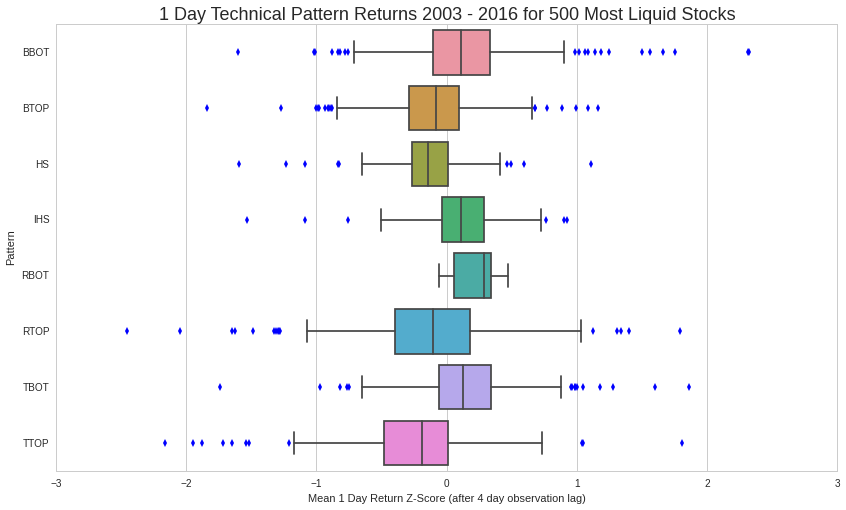

In [24]:
sns.boxplot(pattern_returns.T, orient='h')
plt.title('1 Day Technical Pattern Returns 2003 - 2016 for 500 Most Liquid Stocks', size=18)
plt.xlabel('Mean 1 Day Return Z-Score (after 4 day observation lag)')
plt.ylabel('Pattern')


Somewhat suprisingly (to me at least), it appears the patterns have significant predicive power with the signs we expected. I'm concerned that the kernel regression was incorperating some lookahead bias that has not been fully mitigated by the four day observation lag. Next step will be to throw this into an algorithm and test for predictive power in a no-look-ahead environment. Please feel free to clone this notebook and use as you see fit!  